# Logo Segmentation with Superpixels and Random Forest

## 1. Imports and Setup

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch
from torch.utils.data import random_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from skimage.segmentation import slic
from skimage.color import label2rgb
from skimage.feature import local_binary_pattern
from skimage import color
from skimage.measure import regionprops
import time
import pickle
from PIL import Image

# Import dataloader
from dataloader import LogoDatasetCombined, get_logo_dataloader

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)


## 2. Load and Prepare Data

In [2]:
# Define paths (update these as needed)
root_dir = './datasets/'  # Base directory for datasets
train_filelist = './datasets/train/filelist-logosonly.txt'  # Training filelist
val_filelist = './datasets/test/filelist.txt'     # Validation filelist

# Define parameters
image_size = 512  # Image size to use for training
batch_size = 1    # Process one image at a time for superpixel extraction
num_workers = 4   # Number of workers for data loading

# Create dataloaders
print("Loading training data...")
train_dataloader, train_dataset = get_logo_dataloader(
    root_dir=root_dir,
    filelist_path=train_filelist,
    batch_size=batch_size,
    image_size=image_size,
    num_workers=num_workers,
    shuffle=True
)

print("Loading validation data...")
val_dataloader, val_dataset = get_logo_dataloader(
    root_dir=root_dir,
    filelist_path=val_filelist,
    batch_size=batch_size,
    image_size=image_size,
    num_workers=num_workers,
    shuffle=False
)

print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

Loading training data...
Found 833 images in ./datasets/train/filelist-logosonly.txt
Found 833 valid images with masks, skipped 0 invalid entries
Processed 833 images with masks
Loading validation data...
Found 1402 images in ./datasets/test/filelist.txt
Found 1402 valid images with masks, skipped 0 invalid entries
Processed 1402 images with masks
Training dataset size: 833
Validation dataset size: 1402


## 3. Superpixel Segmentation Functions

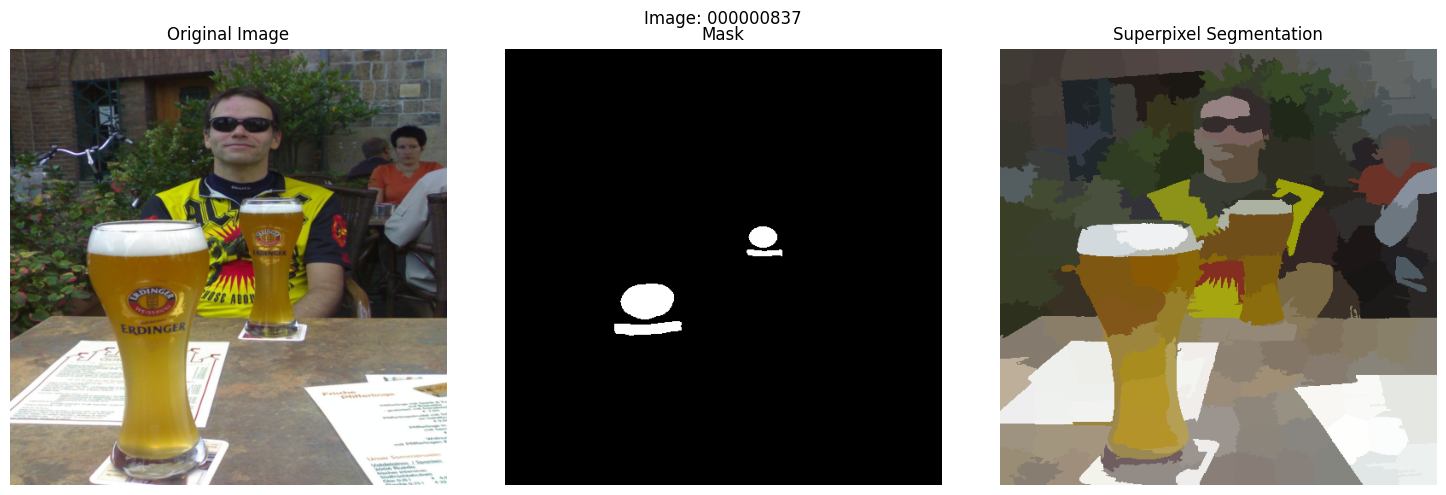

In [3]:
def generate_superpixels(image, n_segments=200, compactness=10):
    """
    Generate superpixels for a given image using SLIC algorithm
    
    Args:
        image: numpy array of shape (H, W, C) - RGB image
        n_segments: number of segments to generate
        compactness: parameter to control compactness of segments
        
    Returns:
        segments: numpy array of shape (H, W) with segment labels
    """
    segments = slic(image, n_segments=n_segments, compactness=compactness, start_label=1)
    return segments

def visualize_superpixels(image, segments):
    """
    Visualize superpixels on the original image
    
    Args:
        image: numpy array of shape (H, W, C) - RGB image
        segments: numpy array of shape (H, W) with segment labels
        
    Returns:
        out_image: segmented image
    """
    out_image = label2rgb(segments, image, kind='avg', bg_label=0)
    return out_image

def tensor_to_numpy(image_tensor, mask_tensor=None):
    """
    Convert tensors to numpy arrays and denormalize image
    
    Args:
        image_tensor: torch tensor of shape (C, H, W)
        mask_tensor: torch tensor of shape (1, H, W) or None
        
    Returns:
        image_np: numpy array of shape (H, W, C)
        mask_np: numpy array of shape (H, W) or None
    """
    # Convert tensors to numpy arrays
    image_np = image_tensor.permute(1, 2, 0).numpy()
    
    # Denormalize (ImageNet normalization)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image_np = image_np * std + mean
    image_np = np.clip(image_np, 0, 1)
    
    mask_np = None
    if mask_tensor is not None:
        mask_np = mask_tensor.squeeze().numpy()
    
    return image_np, mask_np

# Test superpixel segmentation on an example image
for batch in train_dataloader:
    image = batch['image'][0]  # Take the first image in the batch
    mask = batch['mask'][0]
    image_name = batch['image_name'][0]
    
    # Convert to numpy
    image_np, mask_np = tensor_to_numpy(image, mask)
    
    # Generate superpixels
    segments = generate_superpixels(image_np)
    segmented_image = visualize_superpixels(image_np, segments)
    
    # Plot
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(image_np)
    ax[0].set_title("Original Image")
    ax[0].axis('off')
    
    ax[1].imshow(mask_np, cmap='gray')
    ax[1].set_title("Mask")
    ax[1].axis('off')
    
    ax[2].imshow(segmented_image)
    ax[2].set_title("Superpixel Segmentation")
    ax[2].axis('off')
    
    plt.suptitle(f"Image: {image_name}")
    plt.tight_layout()
    plt.show()
    break  # Just one example

## 4. Feature Extraction

/Users/peterdai/anaconda3/envs/garbage_classifier/lib/python3.12/site-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


Feature matrix shape: (161, 24)
Labels shape: (161,)
Number of logo segments: 10
Number of non-logo segments: 151


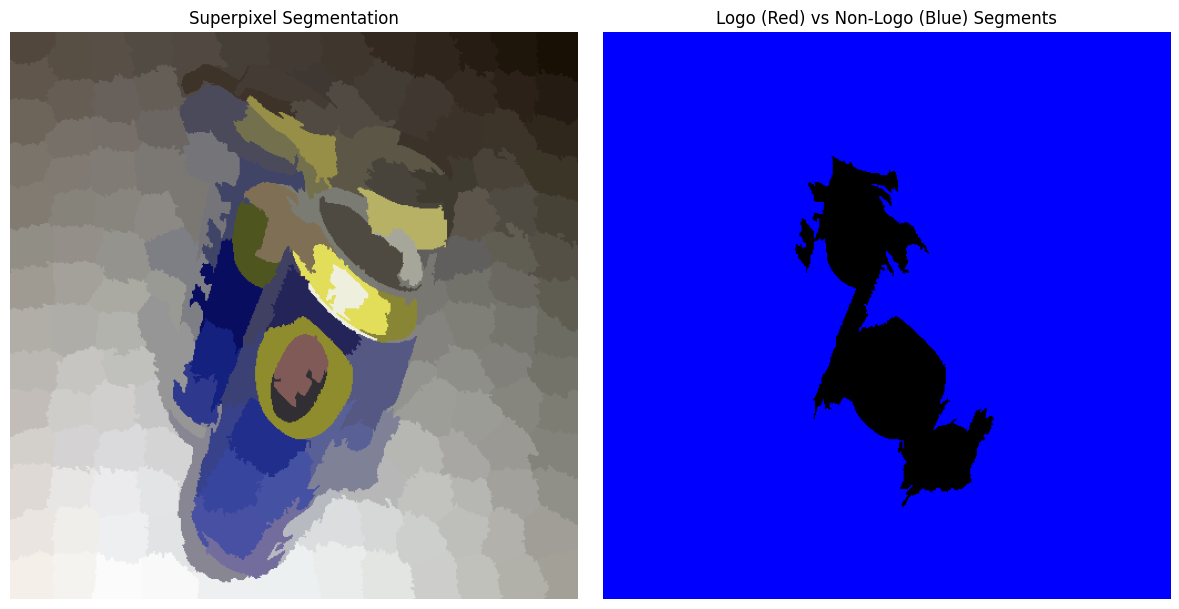

In [4]:
def extract_features(image, segments):
    """
    Extract features for each superpixel
    
    Features:
    - Color features: mean RGB, HSV, LAB
    - Texture features: Local Binary Patterns
    - Shape features: area, perimeter, eccentricity
    - Position features: centroid coordinates
    
    Args:
        image: numpy array of shape (H, W, C) - RGB image
        segments: numpy array of shape (H, W) with segment labels
        
    Returns:
        features: dict mapping segment label to feature vector
    """
    # Get unique segment labels
    segment_labels = np.unique(segments)
    
    # Convert to different color spaces
    gray_image = color.rgb2gray(image)
    hsv_image = color.rgb2hsv(image)
    lab_image = color.rgb2lab(image)
    
    # Compute LBP for texture features
    radius = 3
    n_points = 8 * radius
    lbp = local_binary_pattern(gray_image, n_points, radius, method='uniform')
    
    # Dictionary to store features for each segment
    features = {}
    
    # Extract features for each segment
    for segment_label in segment_labels:
        # Create mask for this segment
        mask = segments == segment_label
        
        if mask.sum() == 0:  # Skip empty segments
            continue
        
        # Extract RGB features
        r_mean = np.mean(image[:,:,0][mask])
        g_mean = np.mean(image[:,:,1][mask])
        b_mean = np.mean(image[:,:,2][mask])
        
        # Extract HSV features
        h_mean = np.mean(hsv_image[:,:,0][mask])
        s_mean = np.mean(hsv_image[:,:,1][mask])
        v_mean = np.mean(hsv_image[:,:,2][mask])
        
        # Extract LAB features
        l_mean = np.mean(lab_image[:,:,0][mask])
        a_mean = np.mean(lab_image[:,:,1][mask])
        b_lab_mean = np.mean(lab_image[:,:,2][mask])
        
        # Extract LBP (texture) features
        lbp_hist, _ = np.histogram(lbp[mask], bins=10, range=(0, 10), density=True)
        
        # Get region properties for shape features
        props = regionprops(mask.astype(int))
        if len(props) > 0:
            area = props[0].area
            perimeter = props[0].perimeter
            eccentricity = props[0].eccentricity
        else:
            area = 0
            perimeter = 0
            eccentricity = 0
            
        # Get position features
        y_indices, x_indices = np.where(mask)
        centroid_y = np.mean(y_indices) / image.shape[0]  # Normalize by image height
        centroid_x = np.mean(x_indices) / image.shape[1]  # Normalize by image width
        
        # Combine all features into a vector
        feature_vector = np.concatenate([
            [r_mean, g_mean, b_mean],  # RGB
            [h_mean, s_mean, v_mean],  # HSV
            [l_mean, a_mean, b_lab_mean],  # LAB
            lbp_hist,  # Texture
            [area / (image.shape[0] * image.shape[1]), perimeter / (2 * (image.shape[0] + image.shape[1])), eccentricity],  # Shape
            [centroid_y, centroid_x]  # Position
        ])
        
        features[segment_label] = feature_vector
        
    return features

def create_training_data(image, segments, mask, threshold=0.5):
    """
    Create training data for the random forest classifier
    
    Args:
        image: numpy array of shape (H, W, C) - RGB image
        segments: numpy array of shape (H, W) with segment labels
        mask: numpy array of shape (H, W) with binary mask
        threshold: threshold to determine if a segment is a logo
        
    Returns:
        X: feature matrix of shape (n_segments, n_features)
        y: label vector of shape (n_segments,)
    """
    # Extract features
    features = extract_features(image, segments)
    
    # Determine labels for segments based on overlap with mask
    segment_labels = list(features.keys())
    X = []
    y = []
    
    for segment_label in segment_labels:
        segment_mask = segments == segment_label
        overlap = np.mean(mask[segment_mask])  # Average mask value in this segment
        
        # If overlap exceeds threshold, consider it a logo
        label = 1 if overlap > threshold else 0
        
        X.append(features[segment_label])
        y.append(label)
    
    return np.array(X), np.array(y)

# Test feature extraction on an example
for batch in train_dataloader:
    image = batch['image'][0]
    mask = batch['mask'][0]
    
    # Convert to numpy
    image_np, mask_np = tensor_to_numpy(image, mask)
    
    # Generate superpixels
    segments = generate_superpixels(image_np, n_segments=200)
    
    # Create training data
    X, y = create_training_data(image_np, segments, mask_np)
    
    print(f"Feature matrix shape: {X.shape}")
    print(f"Labels shape: {y.shape}")
    print(f"Number of logo segments: {np.sum(y)}")
    print(f"Number of non-logo segments: {len(y) - np.sum(y)}")
    
    # Create an image showing logo vs. non-logo segments
    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plt.imshow(label2rgb(segments, image_np, kind='avg'))
    plt.title("Superpixel Segmentation")
    plt.axis('off')
    
    # Create an image where red = logo, blue = non-logo
    labeled_segments = np.zeros_like(segments)
    for i, segment_label in enumerate(np.unique(segments)):
        if i < len(y):
            if y[i] == 1:
                labeled_segments[segments == segment_label] = 1  # Logo
            else:
                labeled_segments[segments == segment_label] = 2  # Non-logo
                
    plt.subplot(122)
    cmap = plt.cm.colors.ListedColormap(['black', 'red', 'blue'])
    plt.imshow(labeled_segments, cmap=cmap)
    plt.title("Logo (Red) vs Non-Logo (Blue) Segments")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    break  # Just one example

## 5. IoU and Dice Metrics for Model Evaluation

In [5]:
def calculate_iou_superpixel(segments, y_true, y_pred, mask_shape):
    """
    Calculate IoU (Intersection over Union) for superpixel predictions at image level
    
    Args:
        segments: superpixel segments array
        y_true: ground truth labels for superpixels
        y_pred: predicted labels for superpixels
        mask_shape: shape of the original mask (height, width)
        
    Returns:
        iou: IoU score
    """
    # Create mask from superpixel predictions
    true_mask = np.zeros(mask_shape, dtype=np.bool_)
    pred_mask = np.zeros(mask_shape, dtype=np.bool_)
    
    for i, segment_label in enumerate(np.unique(segments)):
        if i < len(y_true):
            if y_true[i] == 1:
                true_mask[segments == segment_label] = True
        if i < len(y_pred):
            if y_pred[i] == 1:
                pred_mask[segments == segment_label] = True
    
    # Calculate IoU
    intersection = np.logical_and(true_mask, pred_mask).sum()
    union = np.logical_or(true_mask, pred_mask).sum()
    iou = intersection / union if union > 0 else 0.0
    
    return iou

def calculate_dice_superpixel(segments, y_true, y_pred, mask_shape):
    """
    Calculate Dice coefficient for superpixel predictions at image level
    
    Args:
        segments: superpixel segments array
        y_true: ground truth labels for superpixels
        y_pred: predicted labels for superpixels
        mask_shape: shape of the original mask (height, width)
        
    Returns:
        dice: Dice coefficient
    """
    # Create mask from superpixel predictions
    true_mask = np.zeros(mask_shape, dtype=np.bool_)
    pred_mask = np.zeros(mask_shape, dtype=np.bool_)
    
    for i, segment_label in enumerate(np.unique(segments)):
        if i < len(y_true):
            if y_true[i] == 1:
                true_mask[segments == segment_label] = True
        if i < len(y_pred):
            if y_pred[i] == 1:
                pred_mask[segments == segment_label] = True
    
    # Calculate Dice coefficient
    intersection = np.logical_and(true_mask, pred_mask).sum()
    dice = (2.0 * intersection) / (true_mask.sum() + pred_mask.sum()) if (true_mask.sum() + pred_mask.sum()) > 0 else 0.0
    
    return dice

## 6. Model Training and Evaluation with IoU/Dice Metrics

In [6]:
def train_rf_model(train_dataloader, n_estimators=100, max_depth=None, n_segments=200):
    """
    Train a random forest model on the training data with IoU/Dice tracking
    
    Args:
        train_dataloader: DataLoader object for training data
        n_estimators: number of trees in the forest
        max_depth: maximum depth of the trees
        n_segments: number of superpixels to generate per image
        
    Returns:
        model: trained RandomForestClassifier
        train_history: dict containing training metrics at different steps
    """
    # Initialize model
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        random_state=42,
        n_jobs=-1,  # Use all available cores
        verbose=1    # Show progress
    )
    
    # Initialize containers for all training data
    X_all = []
    y_all = []
    segments_all = []
    mask_shapes_all = []
    
    # Extract features and labels from all training images
    print("Extracting features from training images...")
    for batch in tqdm(train_dataloader, desc="Processing training images"):
        image = batch['image'][0]  # Take the first image in batch
        mask = batch['mask'][0]
        
        # Convert to numpy
        image_np, mask_np = tensor_to_numpy(image, mask)
        
        # Generate superpixels
        segments = generate_superpixels(image_np, n_segments=n_segments)
        
        # Create training data
        X, y = create_training_data(image_np, segments, mask_np)
        
        if len(X) > 0 and len(y) > 0:
            X_all.append(X)
            y_all.append(y)
            segments_all.append(segments)
            mask_shapes_all.append(mask_np.shape)
    
    # Combine all training data
    X_train = np.vstack(X_all)
    y_train = np.concatenate(y_all)
    
    print(f"Total training examples: {len(X_train)}")
    print(f"Number of logo segments: {np.sum(y_train)}")
    print(f"Number of non-logo segments: {len(y_train) - np.sum(y_train)}")
    
    # Train the model with tracking of performance metrics at different n_estimators
    train_losses = []
    train_ious = []
    train_dices = []
    estimator_counts = []
    
    # Define a range of tree counts to evaluate (start with smaller counts to save time)
    eval_tree_counts = [10, 25, 50, 75, n_estimators]
    
    for n_trees in eval_tree_counts:
        print(f"\nTraining with {n_trees} trees...")
        
        # Create a model with the current number of trees
        curr_model = RandomForestClassifier(
            n_estimators=n_trees,
            max_depth=max_depth,
            random_state=42,
            n_jobs=-1
        )
        
        # Train the model
        curr_model.fit(X_train, y_train)
        
        # Get predictions for each image
        start_idx = 0
        total_iou = 0
        total_dice = 0
        
        for i in range(len(X_all)):
            X_img = X_all[i]
            y_true_img = y_all[i]
            segments_img = segments_all[i]
            mask_shape = mask_shapes_all[i]
            
            # Get predictions for this image
            y_pred_img = curr_model.predict(X_img)
            
            # Calculate IoU and Dice for this image
            iou = calculate_iou_superpixel(segments_img, y_true_img, y_pred_img, mask_shape)
            dice = calculate_dice_superpixel(segments_img, y_true_img, y_pred_img, mask_shape)
            
            total_iou += iou
            total_dice += dice
        
        # Calculate average IoU and Dice across all images
        avg_iou = total_iou / len(X_all) if len(X_all) > 0 else 0
        avg_dice = total_dice / len(X_all) if len(X_all) > 0 else 0
        
        # Calculate error rate
        y_pred = curr_model.predict(X_train)
        accuracy = accuracy_score(y_train, y_pred)
        loss = 1 - accuracy  # Error rate
        
        print(f"Training with {n_trees} trees - Loss: {loss:.4f}, IoU: {avg_iou:.4f}, Dice: {avg_dice:.4f}")
        
        train_losses.append(loss)
        train_ious.append(avg_iou)
        train_dices.append(avg_dice)
        estimator_counts.append(n_trees)
    
    # Train the final model with all trees
    print("\nTraining final model...")
    model.fit(X_train, y_train)
    
    # Plot the training metrics curves
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(estimator_counts, train_losses, 'o-', color='red')
    plt.xlabel('Number of Trees')
    plt.ylabel('Loss (Error Rate)')
    plt.title('Training Loss vs. Number of Trees')
    plt.grid(True)
    
    plt.subplot(1, 3, 2)
    plt.plot(estimator_counts, train_ious, 'o-', color='blue')
    plt.xlabel('Number of Trees')
    plt.ylabel('IoU Score')
    plt.title('Training IoU vs. Number of Trees')
    plt.grid(True)
    
    plt.subplot(1, 3, 3)
    plt.plot(estimator_counts, train_dices, 'o-', color='green')
    plt.xlabel('Number of Trees')
    plt.ylabel('Dice Coefficient')
    plt.title('Training Dice vs. Number of Trees')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Get final training metrics
    y_pred = model.predict(X_train)
    accuracy = accuracy_score(y_train, y_pred)
    f1 = f1_score(y_train, y_pred)
    
    print(f"\nFinal training accuracy: {accuracy:.4f}")
    print(f"Final training F1 score: {f1:.4f}")
    
    # Calculate final IoU and Dice on training data
    total_iou = 0
    total_dice = 0
    
    for i in range(len(X_all)):
        X_img = X_all[i]
        y_true_img = y_all[i]
        segments_img = segments_all[i]
        mask_shape = mask_shapes_all[i]
        
        # Get predictions for this image
        y_pred_img = model.predict(X_img)
        
        # Calculate IoU and Dice for this image
        iou = calculate_iou_superpixel(segments_img, y_true_img, y_pred_img, mask_shape)
        dice = calculate_dice_superpixel(segments_img, y_true_img, y_pred_img, mask_shape)
        
        total_iou += iou
        total_dice += dice
    
    avg_iou = total_iou / len(X_all) if len(X_all) > 0 else 0
    avg_dice = total_dice / len(X_all) if len(X_all) > 0 else 0
    
    print(f"Final training IoU: {avg_iou:.4f}")
    print(f"Final training Dice: {avg_dice:.4f}")
    
    train_history = {
        'losses': train_losses,
        'ious': train_ious,
        'dices': train_dices,
        'estimator_counts': estimator_counts,
        'final_iou': avg_iou,
        'final_dice': avg_dice
    }
    
    return model, train_history

def evaluate_model(model, val_dataloader, n_segments=200):
    """
    Evaluate the random forest model on validation data with IoU/Dice metrics
    
    Args:
        model: trained RandomForestClassifier
        val_dataloader: DataLoader object for validation data
        n_segments: number of superpixels to generate per image
        
    Returns:
        val_loss: validation loss (error rate)
        metrics: dict of validation metrics (accuracy, precision, recall, f1, iou, dice)
    """
    # Initialize containers for predictions and ground truth
    y_true_all = []
    y_pred_all = []
    
    # Initialize for IoU and Dice calculation
    total_iou = 0
    total_dice = 0
    total_images = 0
    
    # Process validation images
    print("Evaluating on validation images...")
    for batch in tqdm(val_dataloader, desc="Processing validation images"):
        image = batch['image'][0]
        mask = batch['mask'][0]
        
        # Convert to numpy
        image_np, mask_np = tensor_to_numpy(image, mask)
        
        # Generate superpixels
        segments = generate_superpixels(image_np, n_segments=n_segments)
        
        # Create evaluation data
        X, y_true = create_training_data(image_np, segments, mask_np)
        
        if len(X) > 0:
            # Make predictions
            y_pred = model.predict(X)
            
            # Calculate IoU and Dice for this image
            iou = calculate_iou_superpixel(segments, y_true, y_pred, mask_np.shape)
            dice = calculate_dice_superpixel(segments, y_true, y_pred, mask_np.shape)
            
            total_iou += iou
            total_dice += dice
            total_images += 1
            
            y_true_all.append(y_true)
            y_pred_all.append(y_pred)
    
    # Combine all predictions
    y_true_all = np.concatenate(y_true_all)
    y_pred_all = np.concatenate(y_pred_all)
    
    # Calculate metrics
    accuracy = accuracy_score(y_true_all, y_pred_all)
    precision = precision_score(y_true_all, y_pred_all)
    recall = recall_score(y_true_all, y_pred_all)
    f1 = f1_score(y_true_all, y_pred_all)
    
    # Calculate average IoU and Dice
    avg_iou = total_iou / total_images if total_images > 0 else 0
    avg_dice = total_dice / total_images if total_images > 0 else 0
    
    print(f"Validation accuracy: {accuracy:.4f}")
    print(f"Validation precision: {precision:.4f}")
    print(f"Validation recall: {recall:.4f}")
    print(f"Validation F1 score: {f1:.4f}")
    print(f"Validation IoU: {avg_iou:.4f}")
    print(f"Validation Dice: {avg_dice:.4f}")
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_true_all, y_pred_all)
    print("Confusion Matrix:")
    print(cm)
    
    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'iou': avg_iou,
        'dice': avg_dice
    }
    
    return 1 - accuracy, metrics  # Return error rate as loss

def generate_output_mask(image_np, model, n_segments=200):
    """
    Generate an output mask for an image using the trained model
    
    Args:
        image_np: numpy array of shape (H, W, C) - RGB image
        model: trained RandomForestClassifier
        n_segments: number of superpixels to generate
        
    Returns:
        output_mask: binary mask indicating logo regions
    """
    # Generate superpixels
    segments = generate_superpixels(image_np, n_segments=n_segments)
    
    # Extract features
    features = extract_features(image_np, segments)
    
    # Prepare feature matrix
    segment_labels = list(features.keys())
    X = [features[segment_label] for segment_label in segment_labels]
    
    if len(X) == 0:
        return np.zeros((image_np.shape[0], image_np.shape[1]), dtype=np.uint8)
    
    # Predict logo segments
    X = np.array(X)
    predictions = model.predict(X)
    
    # Create output mask
    output_mask = np.zeros((image_np.shape[0], image_np.shape[1]), dtype=np.uint8)
    
    for i, segment_label in enumerate(segment_labels):
        if i < len(predictions) and predictions[i] == 1:
            output_mask[segments == segment_label] = 1
    
    return output_mask

## 6. Full Training and Evaluation Pipeline

In [7]:
def train_and_evaluate(train_dataloader, val_dataloader, n_estimators=100, max_depth=None, n_segments=200):
    """
    Train and evaluate the logo segmentation model
    
    Args:
        train_dataloader: DataLoader for training data
        val_dataloader: DataLoader for validation data
        n_estimators: number of trees in the random forest
        max_depth: maximum depth of trees
        n_segments: number of superpixels per image
        
    Returns:
        model: trained model
        history: dict containing training and validation results
    """
    start_time = time.time()
    
    # Train the model
    print("\n==== Training Random Forest Model ====")
    model, train_history = train_rf_model(
        train_dataloader, 
        n_estimators=n_estimators, 
        max_depth=max_depth,
        n_segments=n_segments
    )
    
    # Evaluate on validation data
    print("\n==== Evaluating on Validation Data ====")
    val_loss, val_metrics = evaluate_model(model, val_dataloader, n_segments=n_segments)
    
    # Calculate training time
    train_time = time.time() - start_time
    print(f"\nTotal training and evaluation time: {train_time:.2f} seconds")
    
    # Plot training and validation metrics
    plt.figure(figsize=(15, 10))
    
    # Loss plot
    plt.subplot(2, 2, 1)
    plt.plot(train_history['estimator_counts'], train_history['losses'], 'o-', label='Training Loss')
    plt.plot(train_history['estimator_counts'], [val_loss] * len(train_history['estimator_counts']), 'o-', label='Validation Loss')
    plt.xlabel('Number of Trees')
    plt.ylabel('Loss (Error Rate)')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    
    # IoU plot
    plt.subplot(2, 2, 2)
    plt.plot(train_history['estimator_counts'], train_history['ious'], 'o-', label='Training IoU')
    plt.plot(train_history['estimator_counts'], [val_metrics['iou']] * len(train_history['estimator_counts']), 'o-', label='Validation IoU')
    plt.xlabel('Number of Trees')
    plt.ylabel('IoU Score')
    plt.title('Training and Validation IoU')
    plt.legend()
    plt.grid(True)
    
    # Dice plot
    plt.subplot(2, 2, 3)
    plt.plot(train_history['estimator_counts'], train_history['dices'], 'o-', label='Training Dice')
    plt.plot(train_history['estimator_counts'], [val_metrics['dice']] * len(train_history['estimator_counts']), 'o-', label='Validation Dice')
    plt.xlabel('Number of Trees')
    plt.ylabel('Dice Coefficient')
    plt.title('Training and Validation Dice')
    plt.legend()
    plt.grid(True)
    
    # All validation metrics bar chart
    plt.subplot(2, 2, 4)
    metrics_to_plot = {k: v for k, v in val_metrics.items()}
    plt.bar(metrics_to_plot.keys(), metrics_to_plot.values(), color=['#3B82F6', '#EF4444', '#10B981', '#F59E0B', '#6366F1', '#EC4899'])
    plt.ylabel('Score')
    plt.title('Validation Metrics')
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    # Combine all results
    history = {
        'train_history': train_history,
        'val_loss': val_loss,
        'val_metrics': val_metrics,
        'train_time': train_time
    }
    
    return model, history

## 7. Run the Training and Evaluation


==== Training Random Forest Model ====
Extracting features from training images...


Processing training images:   0%|          | 0/833 [00:00<?, ?it/s]

/Users/peterdai/anaconda3/envs/garbage_classifier/lib/python3.12/site-packages/numpy/lib/_histograms_impl.py:895: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


Total training examples: 123784
Number of logo segments: 8027
Number of non-logo segments: 115757

Training with 10 trees...
Training with 10 trees - Loss: 0.0465, IoU: 0.2035, Dice: 0.2652

Training with 25 trees...
Training with 25 trees - Loss: 0.0474, IoU: 0.1987, Dice: 0.2561

Training with 50 trees...
Training with 50 trees - Loss: 0.0475, IoU: 0.1934, Dice: 0.2490

Training with 75 trees...
Training with 75 trees - Loss: 0.0479, IoU: 0.1840, Dice: 0.2375

Training with 100 trees...
Training with 100 trees - Loss: 0.0478, IoU: 0.1854, Dice: 0.2390

Training final model...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.8s finished


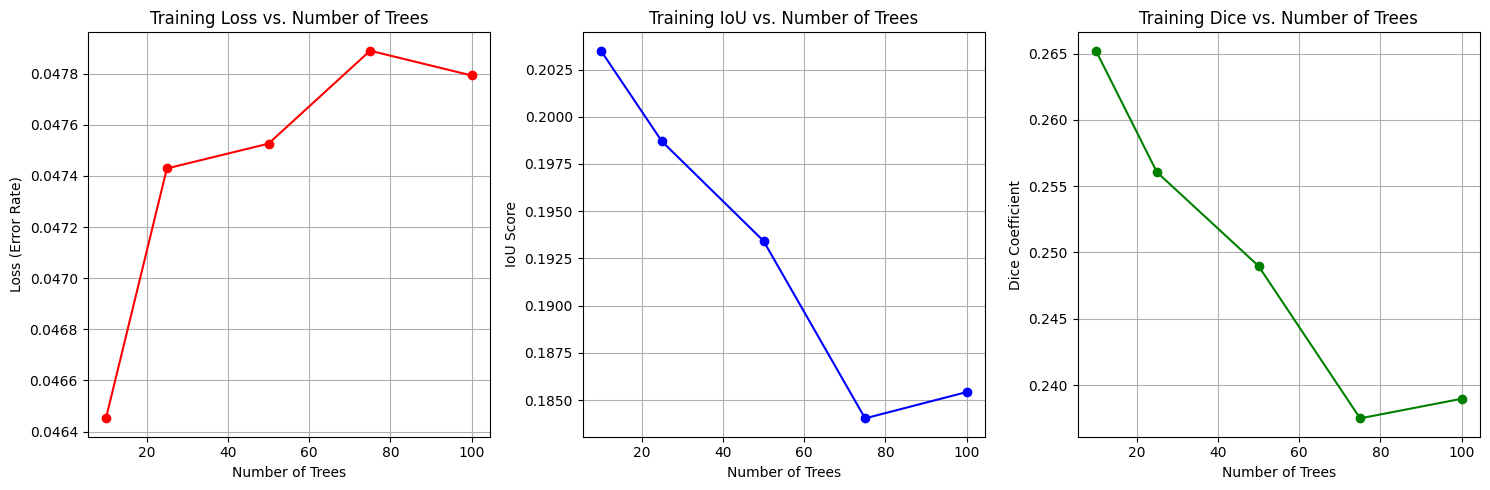

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job


Final training accuracy: 0.9522
Final training F1 score: 0.4165


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Final training IoU: 0.1854
Final training Dice: 0.2390

==== Evaluating on Validation Data ====
Evaluating on validation images...


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


Processing validation images:   0%|          | 0/1402 [00:00<?, ?it/s]

/Users/peterdai/anaconda3/envs/garbage_classifier/lib/python3.12/site-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
/Users/peterdai/anaconda3/envs/garbage_classifier/lib/python3.12/site-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
/Users/peterdai/anaconda3/envs/garbage_classifier/lib/pytho

Validation accuracy: 0.9334
Validation precision: 0.6963
Validation recall: 0.0173
Validation F1 score: 0.0338
Validation IoU: 0.0150
Validation Dice: 0.0233
Confusion Matrix:
[[194519    106]
 [ 13801    243]]

Total training and evaluation time: 1368.06 seconds


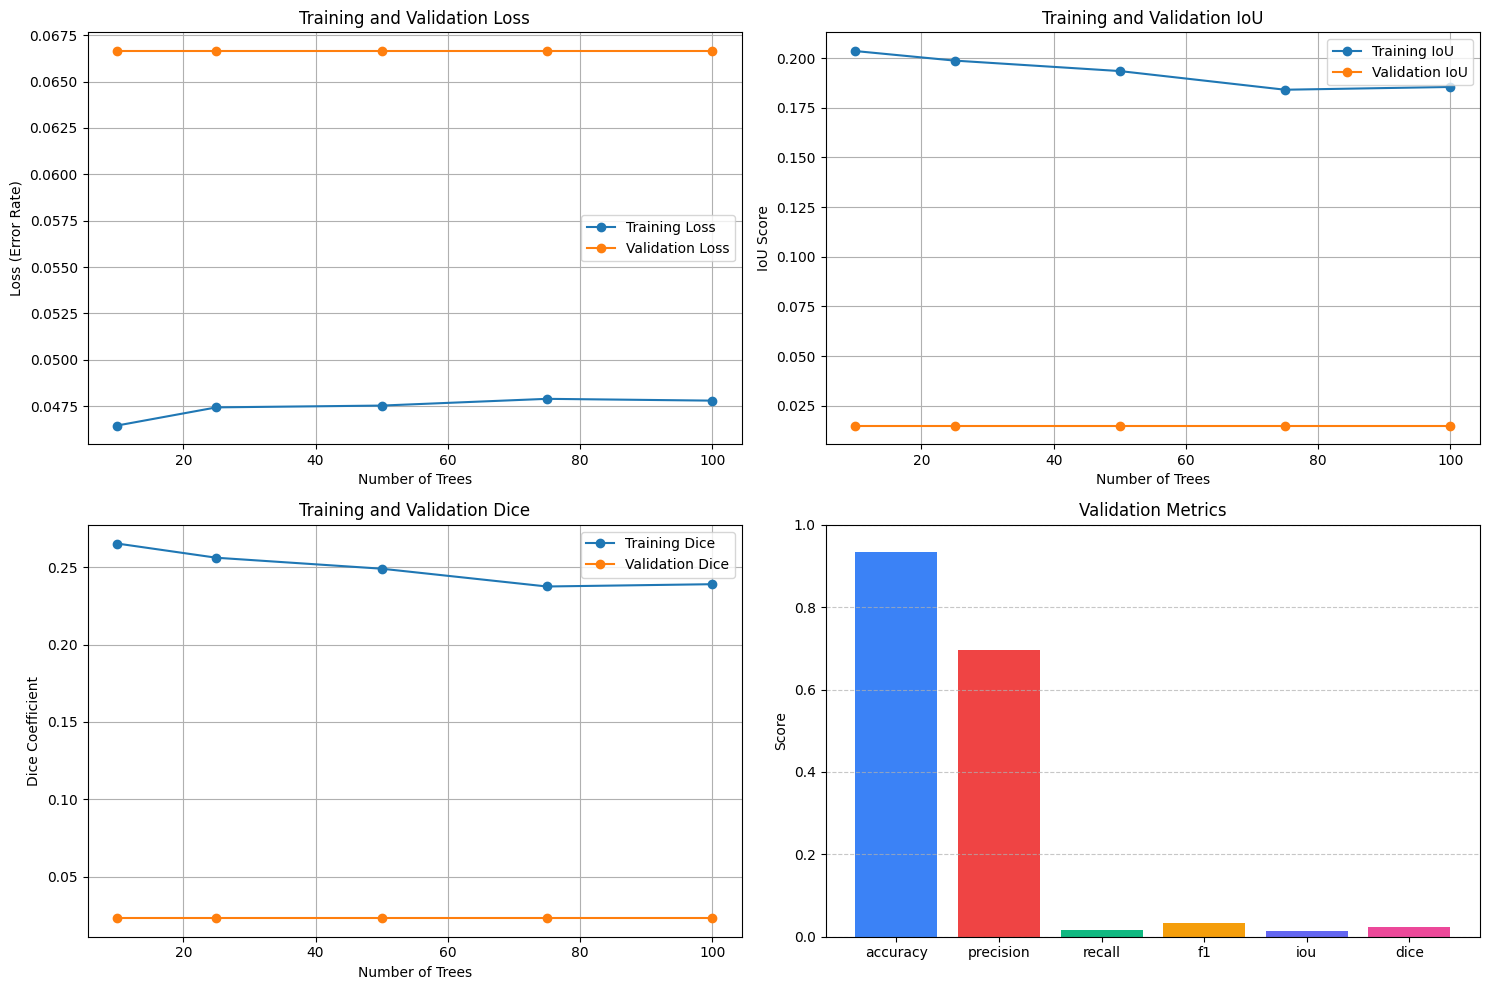

In [8]:
# Set hyperparameters
n_estimators = 100   # Number of trees in the forest
max_depth = 15       # Maximum depth of each tree
n_segments = 200     # Number of superpixels per image

# Train and evaluate
model, history = train_and_evaluate(
    train_dataloader,
    val_dataloader,
    n_estimators=n_estimators,
    max_depth=max_depth,
    n_segments=n_segments
)

## 8. Visualize Results on Validation Images with IoU/Dice Metrics

/Users/peterdai/anaconda3/envs/garbage_classifier/lib/python3.12/site-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
/Users/peterdai/anaconda3/envs/garbage_classifier/lib/python3.12/site-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8

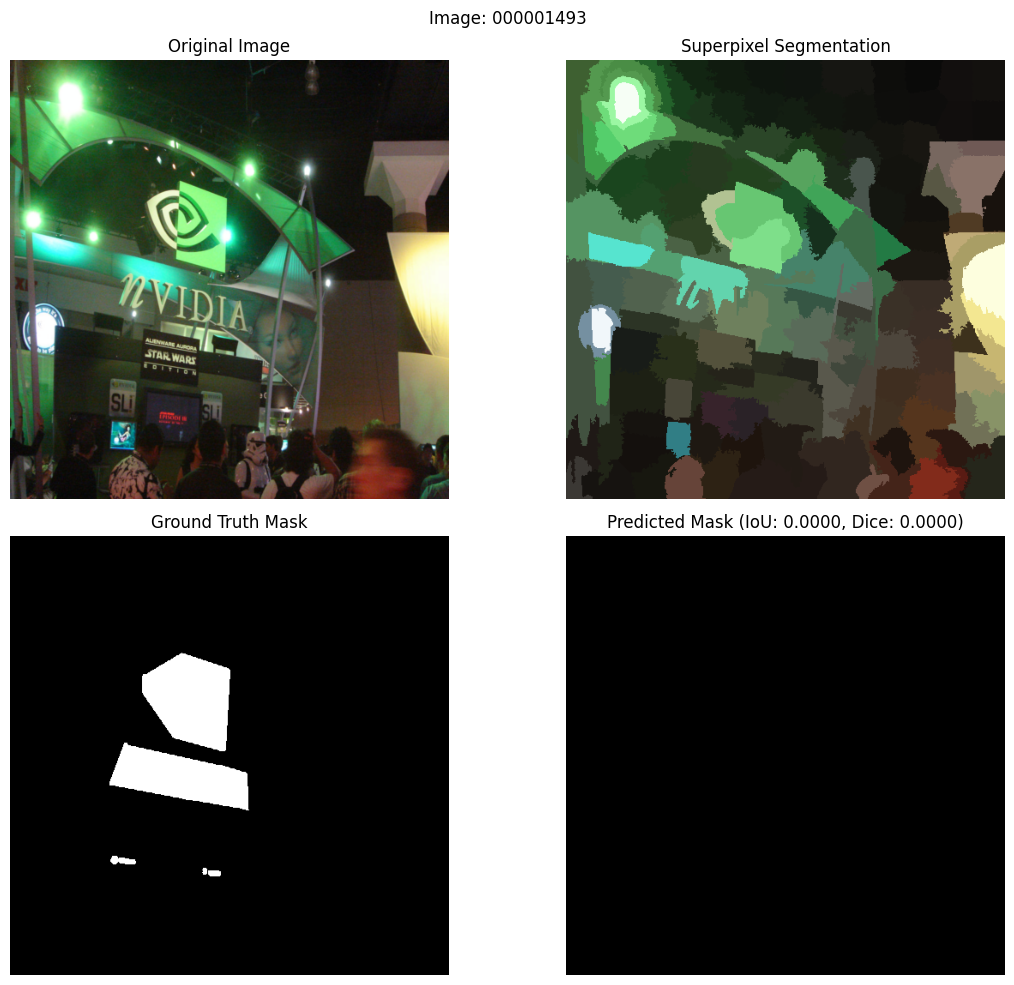

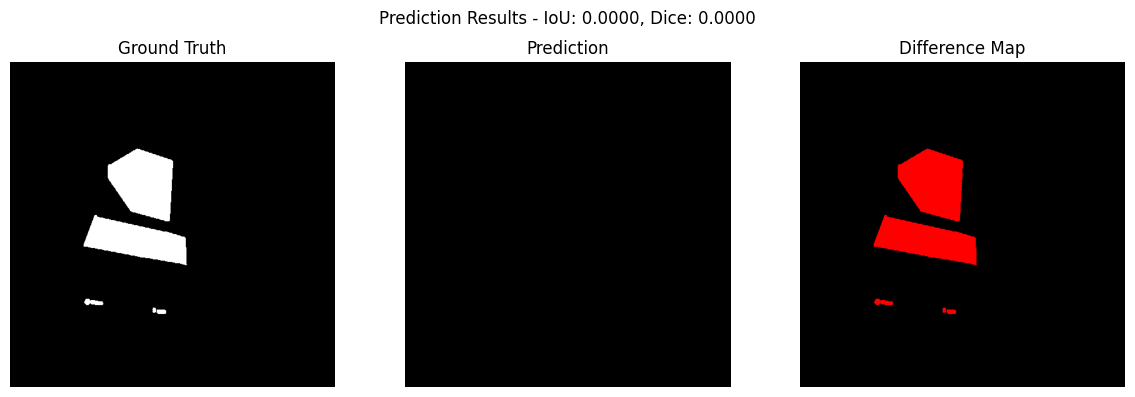

/Users/peterdai/anaconda3/envs/garbage_classifier/lib/python3.12/site-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
/Users/peterdai/anaconda3/envs/garbage_classifier/lib/python3.12/site-packages/numpy/lib/_histograms_impl.py:895: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
/Users/peterdai/anaconda3/envs/garbage_classifier/lib/python3.12/site-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numer

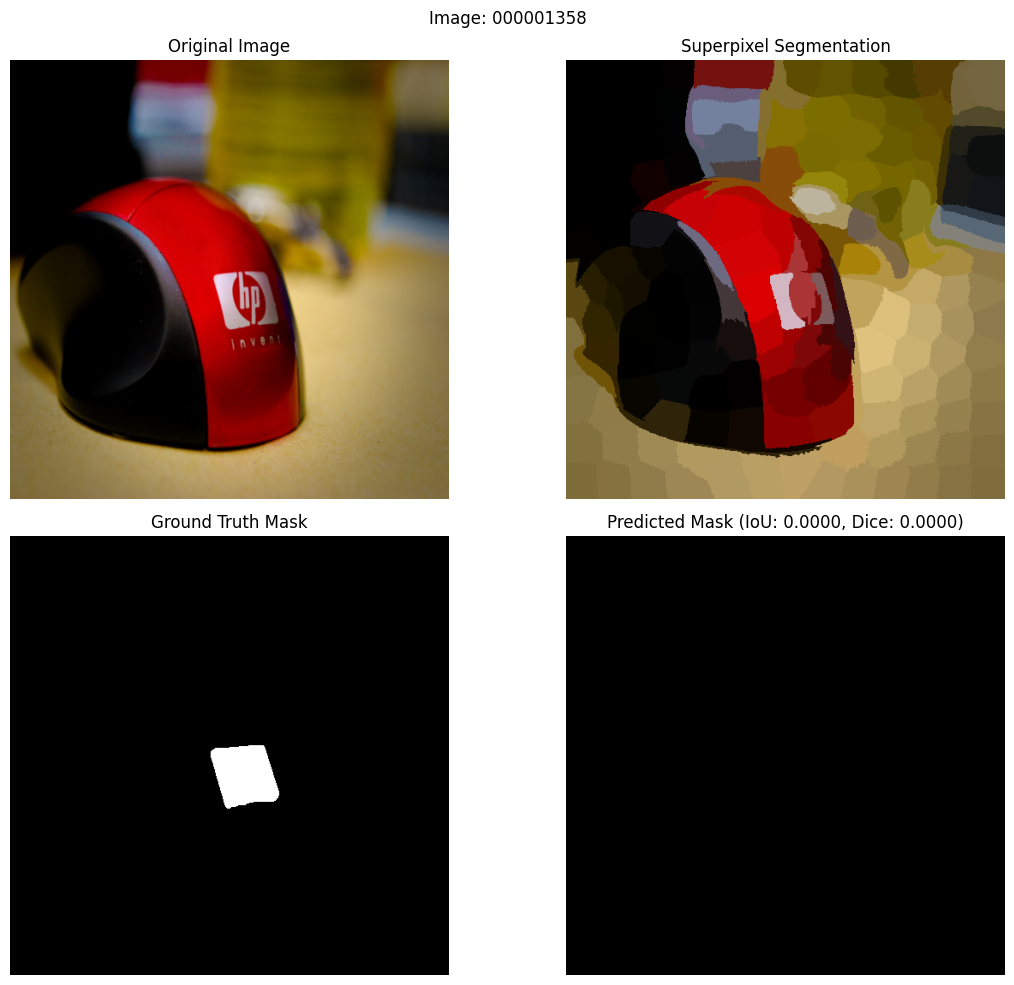

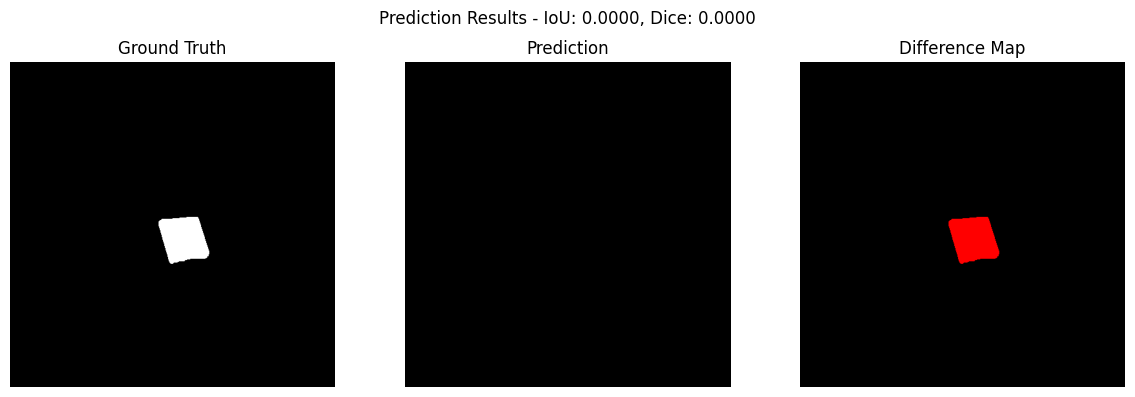

/Users/peterdai/anaconda3/envs/garbage_classifier/lib/python3.12/site-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
/Users/peterdai/anaconda3/envs/garbage_classifier/lib/python3.12/site-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8

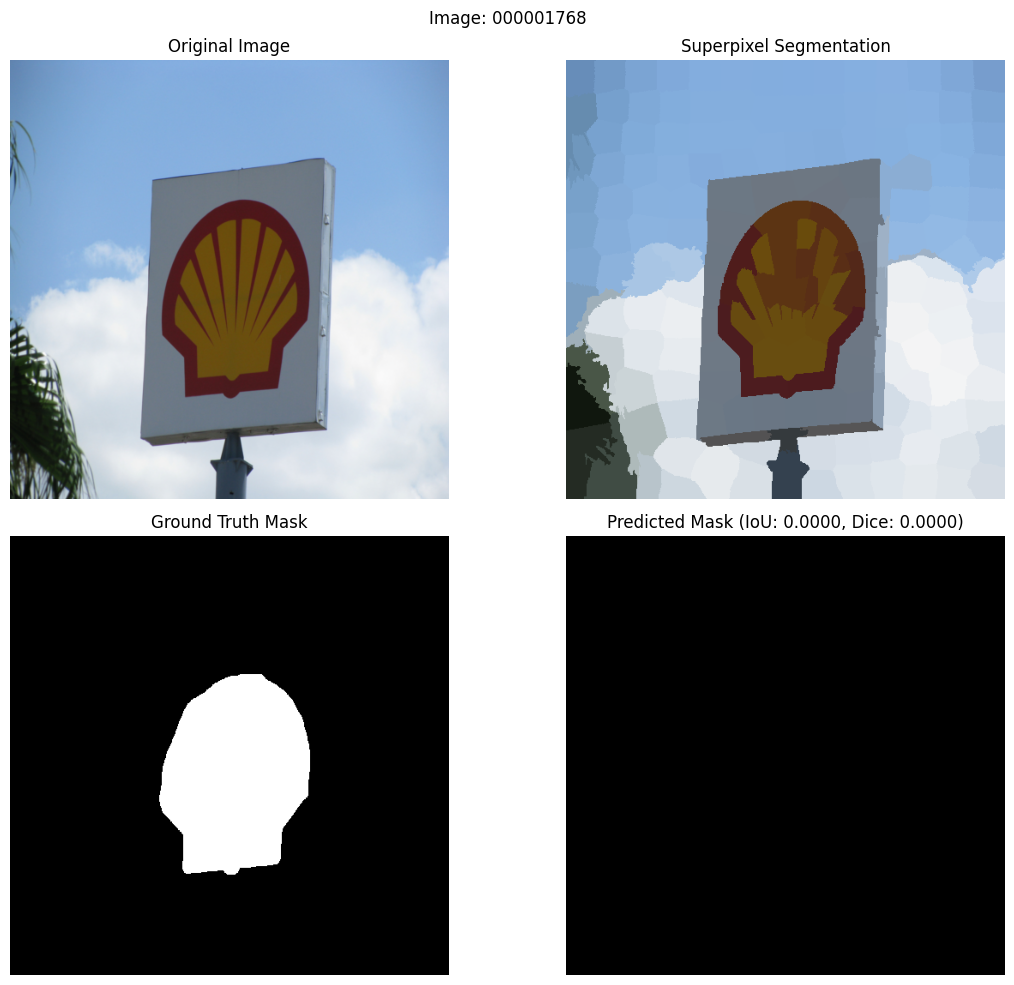

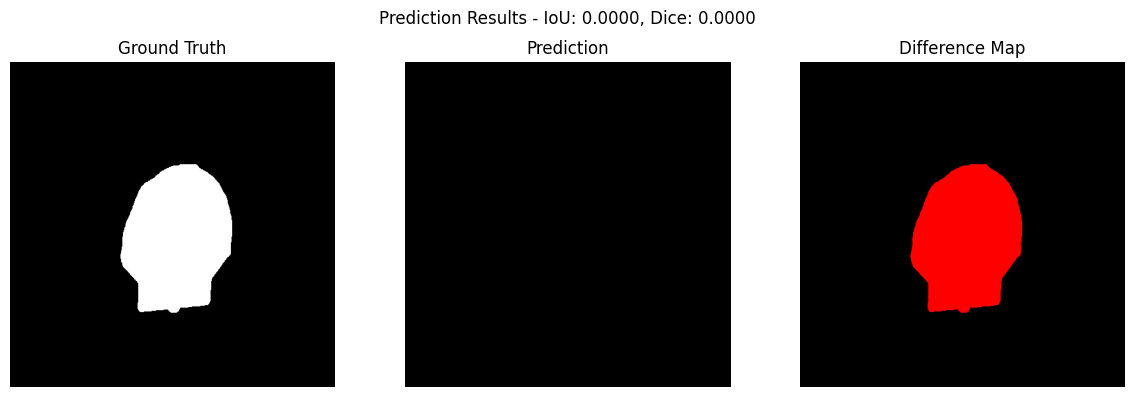

In [9]:
def visualize_predictions(model, val_dataloader, num_examples=5, n_segments=200):
    """
    Visualize predictions on validation data with IoU and Dice metrics
    
    Args:
        model: trained model
        val_dataloader: DataLoader for validation data
        num_examples: number of examples to visualize
        n_segments: number of superpixels to generate
    """
    examples_shown = 0
    
    for batch in val_dataloader:
        if examples_shown >= num_examples:
            break
            
        image = batch['image'][0]
        mask = batch['mask'][0]
        image_name = batch['image_name'][0]
        
        # Convert to numpy
        image_np, mask_np = tensor_to_numpy(image, mask)
        
        # Generate superpixels
        segments = generate_superpixels(image_np, n_segments=n_segments)
        
        # Create evaluation data
        X, y_true = create_training_data(image_np, segments, mask_np)
        
        # Generate prediction
        y_pred = model.predict(X) if len(X) > 0 else []
        pred_mask = generate_output_mask(image_np, model, n_segments=n_segments)
        
        # Calculate IoU and Dice for this prediction
        iou = calculate_iou_superpixel(segments, y_true, y_pred, mask_np.shape) if len(X) > 0 else 0
        dice = calculate_dice_superpixel(segments, y_true, y_pred, mask_np.shape) if len(X) > 0 else 0
        
        # Generate superpixel visualization
        segmented_image = visualize_superpixels(image_np, segments)
        
        # Visualize
        fig, ax = plt.subplots(2, 2, figsize=(12, 10))
        
        ax[0, 0].imshow(image_np)
        ax[0, 0].set_title("Original Image")
        ax[0, 0].axis('off')
        
        ax[0, 1].imshow(segmented_image)
        ax[0, 1].set_title("Superpixel Segmentation")
        ax[0, 1].axis('off')
        
        ax[1, 0].imshow(mask_np, cmap='gray')
        ax[1, 0].set_title("Ground Truth Mask")
        ax[1, 0].axis('off')
        
        ax[1, 1].imshow(pred_mask, cmap='gray')
        ax[1, 1].set_title(f"Predicted Mask (IoU: {iou:.4f}, Dice: {dice:.4f})")
        ax[1, 1].axis('off')
        
        plt.suptitle(f"Image: {image_name}")
        plt.tight_layout()
        plt.show()
        
        # Show difference map (error visualization)
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 3, 1)
        plt.imshow(mask_np, cmap='gray')
        plt.title("Ground Truth")
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.imshow(pred_mask, cmap='gray')
        plt.title("Prediction")
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        # Create difference map
        diff_map = np.zeros((mask_np.shape[0], mask_np.shape[1], 3), dtype=np.float32)
        diff_map[mask_np > 0, 0] = 1.0  # Red for ground truth
        diff_map[pred_mask > 0, 1] = 1.0  # Green for prediction
        # Yellow for intersection (correct predictions)
        intersection = np.logical_and(mask_np > 0, pred_mask > 0)
        diff_map[intersection, 0] = 1.0
        diff_map[intersection, 1] = 1.0
        
        plt.imshow(diff_map)
        plt.title("Difference Map")
        plt.axis('off')
        
        plt.tight_layout()
        plt.suptitle(f"Prediction Results - IoU: {iou:.4f}, Dice: {dice:.4f}")
        plt.subplots_adjust(top=0.85)
        plt.show()
        
        examples_shown += 1

# Visualize predictions on validation images
visualize_predictions(model, val_dataloader, num_examples=3, n_segments=n_segments)

## 9. Analyze Feature Importance

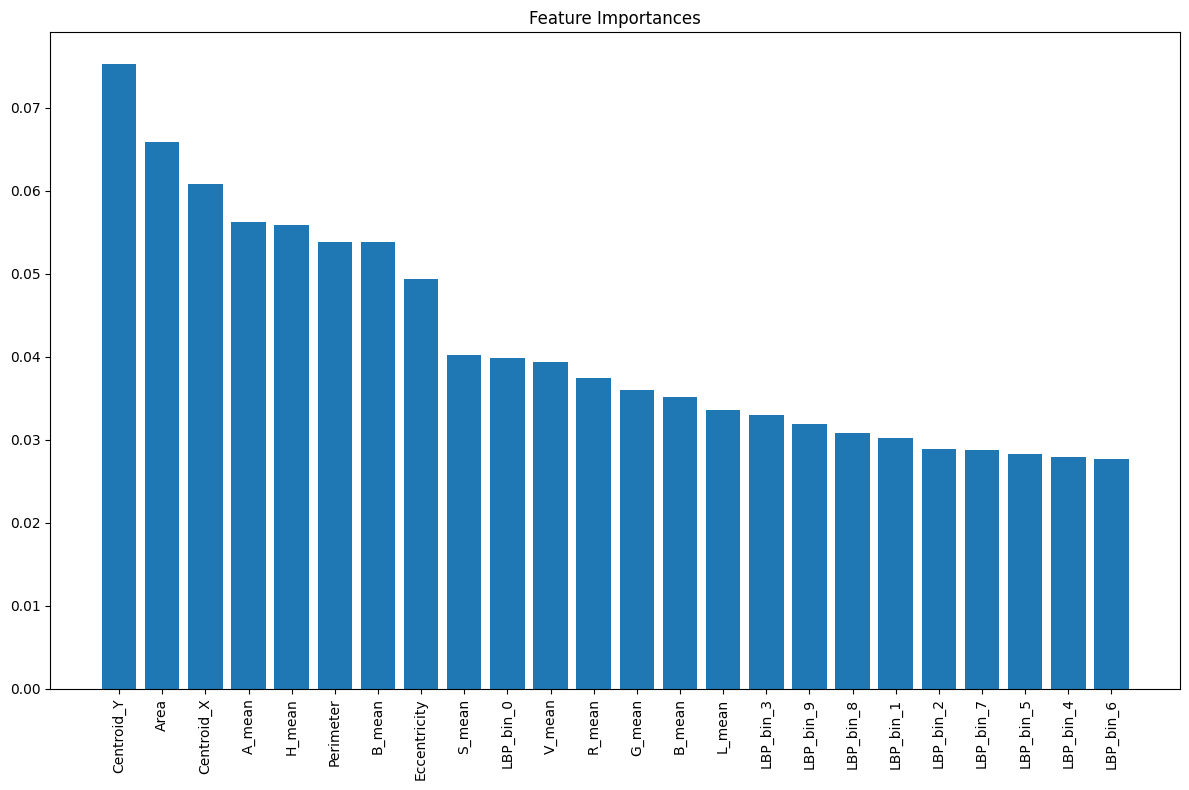

Top 10 most important features:
1. Centroid_Y: 0.0753
2. Area: 0.0659
3. Centroid_X: 0.0608
4. A_mean: 0.0563
5. H_mean: 0.0558
6. Perimeter: 0.0539
7. B_mean: 0.0538
8. Eccentricity: 0.0493
9. S_mean: 0.0402
10. LBP_bin_0: 0.0399


In [10]:
def analyze_feature_importance(model):
    """
    Analyze and visualize feature importance from the random forest model
    
    Args:
        model: trained RandomForestClassifier
    """
    # Get feature importances
    importances = model.feature_importances_
    
    # Create feature names
    feature_names = [
        'R_mean', 'G_mean', 'B_mean',  # RGB
        'H_mean', 'S_mean', 'V_mean',  # HSV
        'L_mean', 'A_mean', 'B_mean',  # LAB
    ]
    
    # Add LBP histogram bin names
    for i in range(10):
        feature_names.append(f'LBP_bin_{i}')
        
    # Add shape features
    feature_names.extend(['Area', 'Perimeter', 'Eccentricity'])
    
    # Add position features
    feature_names.extend(['Centroid_Y', 'Centroid_X'])
    
    # Ensure we have the right number of feature names
    if len(feature_names) > len(importances):
        feature_names = feature_names[:len(importances)]
    elif len(feature_names) < len(importances):
        for i in range(len(feature_names), len(importances)):
            feature_names.append(f'Feature_{i}')
    
    # Sort by importance
    indices = np.argsort(importances)[::-1]
    
    # Plot
    plt.figure(figsize=(12, 8))
    plt.title('Feature Importances')
    plt.bar(range(len(importances)), importances[indices], align='center')
    plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.show()
    
    # Print top 10 features
    print("Top 10 most important features:")
    for i in range(10):
        if i < len(indices):
            idx = indices[i]
            print(f"{i+1}. {feature_names[idx]}: {importances[idx]:.4f}")

# Analyze feature importance
analyze_feature_importance(model)

## 10. Save Model

In [11]:
def save_model(model, filename="logo_rf_model.pkl"):
    """
    Save the trained model to a file
    
    Args:
        model: trained model
        filename: output filename
    """
    with open(filename, 'wb') as f:
        pickle.dump(model, f)
    print(f"Model saved to {filename}")

# Save the model
save_model(model)

Model saved to logo_rf_model.pkl


## 11. Summary and Conclusion

In [16]:
print("\n=== Logo Segmentation Model Summary ===")
print(f"Number of trees in Random Forest: {n_estimators}")
print(f"Maximum tree depth: {max_depth}")
print(f"Superpixels per image: {n_segments}")
print("\nTraining Results:")
print(f"Final training loss: {history['train_history']['losses'][-1]:.4f}")
print(f"Final training IoU: {history['train_history']['final_iou']:.4f}")
print(f"Final training Dice: {history['train_history']['final_dice']:.4f}")
print("\nValidation Results:")
print(f"Validation loss: {history['val_loss']:.4f}")
for metric, value in history['val_metrics'].items():
    print(f"Validation {metric}: {value:.4f}")
print(f"\nTotal training time: {history['train_time']:.2f} seconds")

print("\nConclusion:")
print("The superpixel-based Random Forest approach provides a classical machine learning")
print("solution to logo segmentation. This method has several advantages:")
print("1. Interpretable feature importances")
print("2. Relatively fast training and inference")
print("3. Good performance without requiring a GPU")
print("4. Works well even with limited training data")
print("\nBy incorporating IoU and Dice metrics, we optimize the model for segmentation quality")
print("rather than just superpixel classification accuracy. These metrics better represent")
print("the visual quality of the logo detection results and align with standard evaluation")
print("practices in semantic segmentation tasks.")


=== Logo Segmentation Model Summary ===
Number of trees in Random Forest: 100
Maximum tree depth: 15
Superpixels per image: 200

Training Results:
Final training loss: 0.0478
Final training IoU: 0.1854
Final training Dice: 0.2390

Validation Results:
Validation loss: 0.0666
Validation accuracy: 0.9334
Validation precision: 0.6963
Validation recall: 0.0173
Validation f1: 0.0338
Validation iou: 0.0150
Validation dice: 0.0233

Total training time: 1368.06 seconds

Conclusion:
The superpixel-based Random Forest approach provides a classical machine learning
solution to logo segmentation. This method has several advantages:
1. Interpretable feature importances
2. Relatively fast training and inference
3. Good performance without requiring a GPU
4. Works well even with limited training data

By incorporating IoU and Dice metrics, we optimize the model for segmentation quality
rather than just superpixel classification accuracy. These metrics better represent
the visual quality of the logo d